# K-Means Clustering in Python - Market Segmentation

## K-Means Clustering in Python

In [2]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [3]:
root = 'instacart-market-basket-analysis/'

aisles = pd.read_csv(root + 'aisles.csv')
departments = pd.read_csv(root + 'departments.csv')
orders = pd.read_csv(root + 'orders.csv')
order_products_prior = pd.read_csv(root + 'order_products__prior.csv')
order_products_train = pd.read_csv(root + 'order_products__train.csv')
products = pd.read_csv(root + 'products.csv')

In [4]:
order_products = order_products_prior.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')
order_products.shape

(32434489, 15)

In [5]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [6]:
# Cross tabbing
cross_df = pd.crosstab(order_products['user_id'], order_products['aisle'])
cross_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [7]:
# Normalizing
df = cross_df.div(cross_df.sum(axis=1), axis=0)

In [8]:
# Performing PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
features = pca.fit_transform(df)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.113443,0.039084,-0.042863,0.018864,-0.088334,-0.104565,-0.116481,0.083814,-0.062309,-0.025745
1,-0.036988,0.108884,-0.066406,-0.123271,0.098850,-0.033963,-0.054758,-0.053360,-0.020163,-0.007851
2,0.064282,0.103962,0.000710,-0.012221,-0.046983,0.112230,-0.029866,0.007865,0.012653,0.002450
3,-0.093210,0.054093,0.001867,-0.003973,-0.071358,-0.019277,-0.025094,-0.038245,0.006360,-0.000514
4,0.094629,-0.037051,-0.024952,-0.021575,0.055370,0.107648,-0.008036,0.103936,0.051784,-0.025777


In [9]:
import numpy as np
# Adding reordered, order_hour_of_day, days_since_prior_order to df
features2 = order_products.groupby('user_id')[['reordered', 'order_hour_of_day', 'days_since_prior_order']].agg(
    {
        'reordered': np.mean,
        'order_hour_of_day': np.median,
        'days_since_prior_order': np.median
    }
)

scaler = StandardScaler()
scaled_features2 = scaler.fit_transform(features2.values)
scaled_features2 = pd.DataFrame(scaled_features2, index=features2.index, columns=features2.columns)
scaled_features2

features = features.set_index(features2.index)

all_features = pd.merge(features, scaled_features2, left_index=True, right_index=True)
all_features.head()

,0,1,2,3,4,5,6,7,8,9,reordered,order_hour_of_day,days_since_prior_order
user_id,,,,,,,,,,,,,
1,-0.113443,0.039084,-0.042863,0.018864,-0.088334,-0.104565,-0.116481,0.083814,-0.062309,-0.025745,1.238152,-1.589565,0.596797
2,-0.036988,0.108884,-0.066406,-0.123271,0.098850,-0.033963,-0.054758,-0.053360,-0.020163,-0.007851,0.210583,-1.238661,-0.229743
3,0.064282,0.103962,0.000710,-0.012221,-0.046983,0.112230,-0.029866,0.007865,0.012653,0.002450,0.908586,0.866762,-0.560359
4,-0.093210,0.054093,0.001867,-0.003973,-0.071358,-0.019277,-0.025094,-0.038245,0.006360,-0.000514,-1.775655,-0.185950,0.541694
5,0.094629,-0.037051,-0.024952,-0.021575,0.055370,0.107648,-0.008036,0.103936,0.051784,-0.025777,-0.253936,0.866762,-0.450154


In [10]:
kmeans = KMeans(
    init="random", n_clusters=3, n_init=10, max_iter=300, random_state=42
)

In [11]:
kmeans.fit(all_features)

s:\Varun_Projects\Assignments\Marketing_HW\market_HW\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


KMeans(init='random', n_clusters=3, random_state=42)

In [12]:
# The lowest SSE value
kmeans.inertia_

334508.4146980138

In [13]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[ 6.50492817e-03,  1.37816070e-02,  3.47628212e-03,
        -3.66334046e-03,  3.74052953e-03, -1.11431425e-03,
         1.06887316e-03,  3.92713614e-03, -1.31356883e-03,
         2.53704694e-03,  8.03760329e-01, -4.91126309e-01,
        -6.41390124e-01],
       [ 1.55790774e-03, -1.15654760e-02, -4.36832846e-03,
        -2.45613559e-03, -4.05448750e-03,  2.02761752e-03,
        -3.34750040e-04, -2.81801426e-03,  3.05450413e-03,
        -1.32514221e-03, -3.59964883e-01,  7.44855186e-01,
        -4.47486296e-01],
       [-1.00012473e-02, -6.35216000e-03, -1.54081669e-04,
         7.20801494e-03, -8.10420780e-04, -5.76735761e-04,
        -1.05379950e-03, -2.28676436e-03, -1.34287868e-03,
        -1.97172279e-03, -6.84395264e-01, -1.05681663e-01,
         1.27942719e+00]])

In [14]:
# The number of iterations required to converge
kmeans.n_iter_

40

In [15]:
kmeans.labels_[:5]

array([0, 0, 1, 2, 1])

### How to Choose the Number of Clusters

In [16]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(all_features)
    sse.append(kmeans.inertia_)

s:\Varun_Projects\Assignments\Marketing_HW\market_HW\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
s:\Varun_Projects\Assignments\Marketing_HW\market_HW\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
s:\Varun_Projects\Assignments\Marketing_HW\market_HW\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
s:\Varun_Projects\Assignments\Marketing_HW\market_HW\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature 

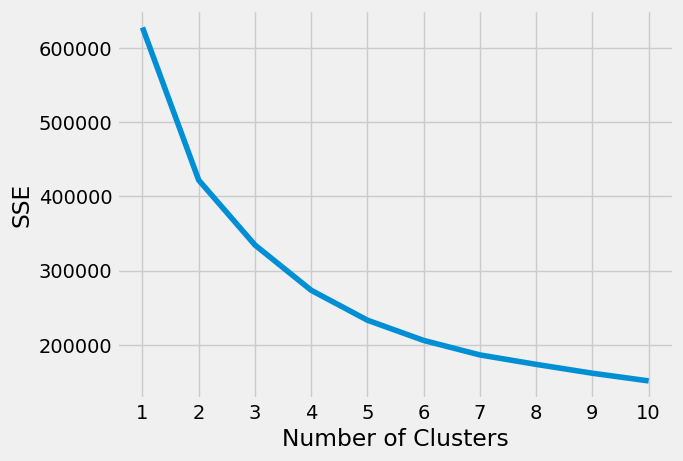

In [17]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [18]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

In [19]:
kl.elbow

4

In [20]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice we start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(all_features)
    score = silhouette_score(all_features, kmeans.labels_)
    silhouette_coefficients.append(score)

s:\Varun_Projects\Assignments\Marketing_HW\market_HW\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
s:\Varun_Projects\Assignments\Marketing_HW\market_HW\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
s:\Varun_Projects\Assignments\Marketing_HW\market_HW\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
s:\Varun_Projects\Assignments\Marketing_HW\market_HW\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature 

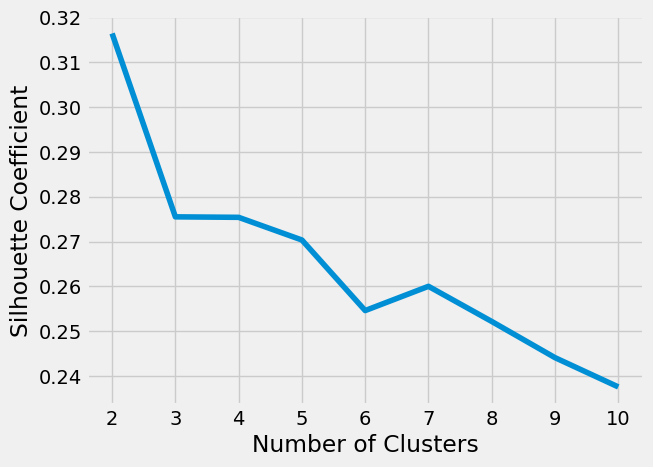

In [21]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [30]:
best_kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
best_kmeans.fit(all_features)

s:\Varun_Projects\Assignments\Marketing_HW\market_HW\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


KMeans(init='random', n_clusters=4, random_state=42)

In [44]:
all_features['cluster'] = best_kmeans.labels_

In [45]:
all_features.head()

,0,1,2,3,4,5,6,7,8,9,reordered,order_hour_of_day,days_since_prior_order,cluster
user_id,,,,,,,,,,,,,,
1,-0.113443,0.039084,-0.042863,0.018864,-0.088334,-0.104565,-0.116481,0.083814,-0.062309,-0.025745,1.238152,-1.589565,0.596797,3
2,-0.036988,0.108884,-0.066406,-0.123271,0.098850,-0.033963,-0.054758,-0.053360,-0.020163,-0.007851,0.210583,-1.238661,-0.229743,3
3,0.064282,0.103962,0.000710,-0.012221,-0.046983,0.112230,-0.029866,0.007865,0.012653,0.002450,0.908586,0.866762,-0.560359,1
4,-0.093210,0.054093,0.001867,-0.003973,-0.071358,-0.019277,-0.025094,-0.038245,0.006360,-0.000514,-1.775655,-0.185950,0.541694,0
5,0.094629,-0.037051,-0.024952,-0.021575,0.055370,0.107648,-0.008036,0.103936,0.051784,-0.025777,-0.253936,0.866762,-0.450154,0


In [46]:
all_features[all_features['cluster']==0]

,0,1,2,3,4,5,6,7,8,9,reordered,order_hour_of_day,days_since_prior_order,cluster
user_id,,,,,,,,,,,,,,
4,-0.093210,0.054093,0.001867,-0.003973,-0.071358,-0.019277,-0.025094,-0.038245,0.006360,-0.000514,-1.775655,-0.185950,0.541694,0
5,0.094629,-0.037051,-0.024952,-0.021575,0.055370,0.107648,-0.008036,0.103936,0.051784,-0.025777,-0.253936,0.866762,-0.450154,0
6,0.116769,-0.205948,0.010542,0.053494,0.010760,0.071964,-0.022054,0.024036,-0.021648,-0.003899,-1.364134,1.217666,-1.001180,0
8,0.206899,-0.249605,0.043062,0.047300,-0.000442,-0.045810,0.006919,-0.017198,-0.018831,-0.007242,-0.786935,-4.747699,1.643747,0
9,-0.108378,0.023737,-0.069915,-0.123244,0.140284,-0.032196,-0.084441,0.002073,-0.026842,0.010974,-0.921108,0.164954,1.643747,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206195,-0.032195,0.007833,-0.040128,0.007006,-0.030915,0.010019,0.009621,0.029159,0.019441,-0.030738,0.002765,-0.185950,-1.111385,0
206196,0.126555,-0.120410,0.066159,0.019793,-0.015080,-0.014493,0.005764,-0.026201,-0.020052,-0.041019,-0.413894,0.515858,1.092721,0
206201,-0.105765,-0.036894,-0.037424,0.020299,-0.037818,-0.010836,0.031265,0.033263,-0.022167,-0.013109,0.646061,-0.185950,-0.229743,0


In [49]:
df_clusters = all_features.merge(orders, left_on='user_id', right_on='user_id', how='left')

In [53]:
df_clusters.head()

,user_id,0,1,2,3,4,5,6,7,8,...,reordered,order_hour_of_day_x,days_since_prior_order_x,cluster,order_id,eval_set,order_number,order_dow,order_hour_of_day_y,days_since_prior_order_y
0,1,-0.113443,0.039084,-0.042863,0.018864,-0.088334,-0.104565,-0.116481,0.083814,-0.062309,...,1.238152,-1.589565,0.596797,3,2539329,prior,1,2,8,NaN
1,1,-0.113443,0.039084,-0.042863,0.018864,-0.088334,-0.104565,-0.116481,0.083814,-0.062309,...,1.238152,-1.589565,0.596797,3,2398795,prior,2,3,7,15.0
2,1,-0.113443,0.039084,-0.042863,0.018864,-0.088334,-0.104565,-0.116481,0.083814,-0.062309,...,1.238152,-1.589565,0.596797,3,473747,prior,3,3,12,21.0
3,1,-0.113443,0.039084,-0.042863,0.018864,-0.088334,-0.104565,-0.116481,0.083814,-0.062309,...,1.238152,-1.589565,0.596797,3,2254736,prior,4,4,7,29.0
4,1,-0.113443,0.039084,-0.042863,0.018864,-0.088334,-0.104565,-0.116481,0.083814,-0.062309,...,1.238152,-1.589565,0.596797,3,431534,prior,5,4,15,28.0


In [59]:
pd.DataFrame(best_kmeans.cluster_centers_, columns=all_features.columns)

,0,1,2,3,4,5,6,7,8,9,reordered,order_hour_of_day,days_since_prior_order,cluster
0,-0.001134,-0.011546,-0.003582,0.001732,-0.003406,0.001155,-0.000200,-0.002520,-0.000218,-0.001375,-0.571307,-0.055320,0.217064,1.556641
1,-0.005998,0.001178,0.002978,0.002983,0.001937,0.000125,-0.001494,-0.000608,0.002244,-0.001233,0.044663,0.876684,0.655404,6.918532
2,0.007554,0.001536,-0.000964,-0.003558,0.000059,0.000893,0.001058,0.001202,-0.000190,0.001431,0.325857,-0.284254,-0.684166,4.470478
3,0.001438,0.031958,0.007432,-0.004844,0.007021,-0.005629,0.001629,0.007072,-0.003382,0.004198,1.142814,-1.026299,-0.719960,9.000000


In [60]:
all_features.to_csv('all_features.csv')

In [64]:
df = pd.read_csv('all_features.csv')
df.head()

,user_id,0,1,2,3,4,5,6,7,8,9,reordered,order_hour_of_day,days_since_prior_order,cluster
0,1,-0.113443,0.039084,-0.042863,0.018864,-0.088334,-0.104565,-0.116481,0.083814,-0.062309,-0.025745,1.238152,-1.589565,0.596797,3
1,2,-0.036988,0.108884,-0.066406,-0.123271,0.098850,-0.033963,-0.054758,-0.053360,-0.020163,-0.007851,0.210583,-1.238661,-0.229743,3
2,3,0.064282,0.103962,0.000710,-0.012221,-0.046983,0.112230,-0.029866,0.007865,0.012653,0.002450,0.908586,0.866762,-0.560359,1
3,4,-0.093210,0.054093,0.001867,-0.003973,-0.071358,-0.019277,-0.025094,-0.038245,0.006360,-0.000514,-1.775655,-0.185950,0.541694,0
4,5,0.094629,-0.037051,-0.024952,-0.021575,0.055370,0.107648,-0.008036,0.103936,0.051784,-0.025777,-0.253936,0.866762,-0.450154,0


In [67]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df.drop(columns=['cluster', 'user_id']))

KMeans(n_clusters=4)

In [69]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df.drop(columns=['cluster', 'user_id']).columns)

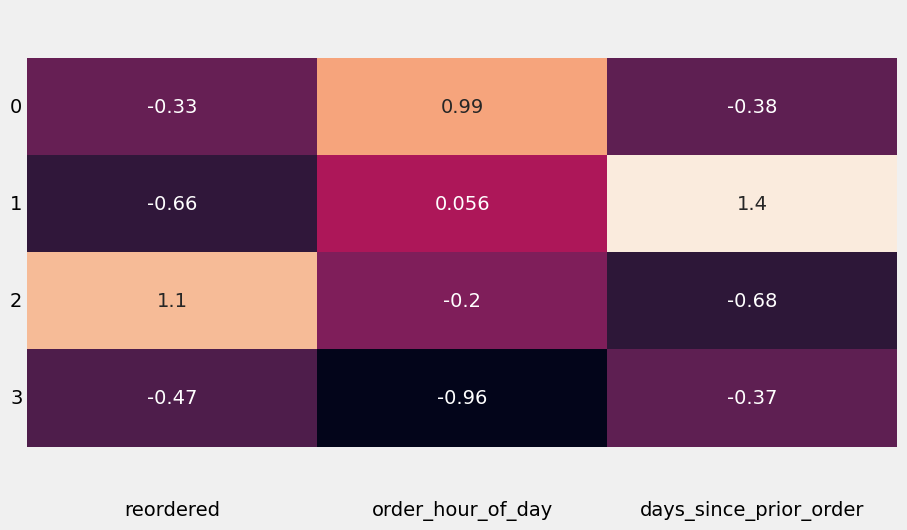

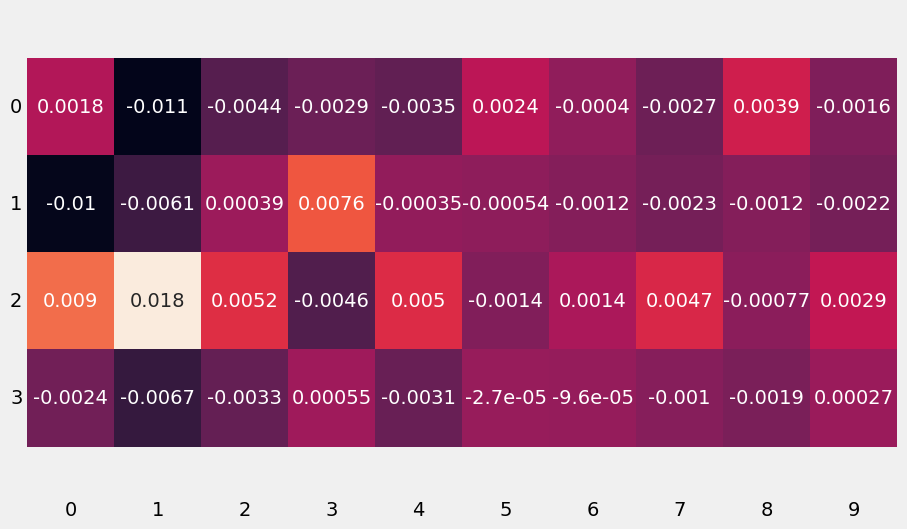

In [84]:
df1 = centroids[['reordered', 'order_hour_of_day', 'days_since_prior_order']]
df2 = centroids[[str(i) for i in range(10)]]

import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(df1, annot=True, cbar=False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df2, annot=True, cbar=False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.show()

In [89]:
cross_df['cluster'] = kmeans.labels_

In [92]:
cluster1 = cross_df[cross_df.cluster == 0]
cluster2 = cross_df[cross_df.cluster == 1]
cluster3 = cross_df[cross_df.cluster == 2]
cluster4 = cross_df[cross_df.cluster == 3]

In [93]:
cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 11.293605
fresh fruits                     10.197305
packaged vegetables fruits        5.454305
yogurt                            4.076827
packaged cheese                   3.087960
water seltzer sparkling water     2.448388
milk                              2.408537
chips pretzels                    2.261293
ice cream ice                     2.082065
soy lactosefree                   1.953740
dtype: float64

In [94]:
cluster2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 6.093320
fresh fruits                     5.505485
packaged vegetables fruits       2.960059
yogurt                           2.292619
packaged cheese                  1.836040
water seltzer sparkling water    1.480614
chips pretzels                   1.356503
milk                             1.279868
soy lactosefree                  1.043078
bread                            1.010208
dtype: float64

In [95]:
cluster3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     39.576674
fresh vegetables                 34.043452
packaged vegetables fruits       18.260254
yogurt                           15.664780
packaged cheese                   9.788780
milk                              9.783087
water seltzer sparkling water     8.766816
chips pretzels                    7.213023
soy lactosefree                   6.649505
bread                             5.966952
dtype: float64

In [96]:
cluster4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 9.576534
fresh fruits                     8.568689
packaged vegetables fruits       4.590591
yogurt                           3.456901
packaged cheese                  2.758235
water seltzer sparkling water    2.181256
milk                             2.130943
chips pretzels                   2.057441
soy lactosefree                  1.643651
bread                            1.565323
dtype: float64

In [98]:
cluster5.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
air fresheners candles   NaN
asian foods              NaN
baby accessories         NaN
baby bath body care      NaN
baby food formula        NaN
bakery desserts          NaN
baking ingredients       NaN
baking supplies decor    NaN
beauty                   NaN
beers coolers            NaN
dtype: float64